In [3]:
import pandas as pd

<H2>System Logs</H2>

In [10]:
structured_system_log = './data/mac/Mac_2k.log_structured.csv'
template_system_log = './data/mac/Mac_2k.log_templates.csv'

In [11]:
structured_system_log_df = pd.read_csv(structured_system_log)
template_system_log_df = pd.read_csv(template_system_log)

In [12]:
structured_system_log_df.head(5)

,LineId,Month,Date,Time,User,Component,PID,Address,Content,EventId,EventTemplate
0,1,Jul,1,09:00:55,calvisitor-10-105-160-95,kernel,0,NaN,IOThunderboltSwitch<0>(0x0)::listenerCallback ...,E252,IOThunderboltSwitch<<*>>(<*>)::listenerCallbac...
1,2,Jul,1,09:01:05,calvisitor-10-105-160-95,com.apple.CDScheduler,43,NaN,Thermal pressure state: 1 Memory pressure stat...,E323,Thermal pressure state: <*> Memory pressure st...
2,3,Jul,1,09:01:06,calvisitor-10-105-160-95,QQ,10018,NaN,FA||Url||taskID[2019352994] dealloc,E216,FA||Url||taskID[<*>] dealloc
3,4,Jul,1,09:02:26,calvisitor-10-105-160-95,kernel,0,NaN,ARPT: 620701.011328: AirPort_Brcm43xx::syncPow...,E128,ARPT: <*>.<*>: AirPort_<*>::syncPowerState: WW...
4,5,Jul,1,09:02:26,authorMacBook-Pro,kernel,0,NaN,ARPT: 620702.879952: AirPort_Brcm43xx::platfor...,E124,ARPT: <*>.<*>: AirPort_<*>::platformWoWEnable:...


descriptive statistics

In [14]:
# EventID
event_freq = structured_system_log_df['EventId'].value_counts()
top_5_event_freq = event_freq.head(5)
top_5_event_freq


EventId
E189    166
E188     71
E120     56
E203     44
E323     39
Name: count, dtype: int64

In [17]:
# Component Logging Occurance
component_freq = structured_system_log_df['Component'].value_counts()
top_5_component_freq = component_freq.head(5)
top_5_component_freq

Component
kernel            775
com.apple.cts     166
corecaptured      158
QQ                 75
Microsoft Word     72
Name: count, dtype: int64

In [19]:
# Top user
user_freq = structured_system_log_df['User'].value_counts()
top_5_user_freq = user_freq.head(5)
top_5_user_freq

User
authorMacBook-Pro            554
calvisitor-10-105-162-105    338
calvisitor-10-105-162-178    256
calvisitor-10-105-160-95     140
calvisitor-10-105-163-202    137
Name: count, dtype: int64

In [44]:
# Top PID
pid_freq = structured_system_log_df['PID'].value_counts()
top_5_pid_freq = pid_freq.head(5)
top_5_pid_freq

PID
0        775
258      151
43        77
10018     75
14463     72
Name: count, dtype: int64

Anomaly Detection

In [22]:
# Rare event
rare_event = event_freq[event_freq == event_freq.min()]
rare_event.count()

135

In [121]:
# Spike in event over a minute
structured_system_log_df['Datetime'] = pd.to_datetime(structured_system_log_df['Time'], format = '%H:%M:%S')
time_series = structured_system_log_df.groupby(['Month', 'Date']).apply(
    lambda group: group.set_index('Datetime').resample('min').size()
)

top_5_spikes = time_series.nlargest(5)
top_5_spikes


/var/folders/kl/91sz4j8n53j318l8bcb5qjkh0000gn/T/ipykernel_30428/1421129578.py:3: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



Month  Date  Datetime           
Jul    4     1900-01-01 23:22:00    72
       3     1900-01-01 16:07:00    17
       5     1900-01-01 14:04:00    17
       7     1900-01-01 13:40:00    14
             1900-01-01 13:42:00    13
dtype: int64

In [372]:
fouth_of_july_df = structured_system_log_df[(structured_system_log_df['Month']=='Jul') & (structured_system_log_df['Date']== 4)]
spike_df = fouth_of_july_df[(fouth_of_july_df["Time"] >= "23:22:00") & (fouth_of_july_df["Time"] < "23:23:00")]
spike_df.groupby(["EventId"])["EventId"].value_counts()


EventId
E188    71
E9       1
Name: count, dtype: int64

Period of Inactivity

In [233]:
date_time_structured_system_log_df = structured_system_log_df
date_time_structured_system_log_df['DateTime'] = pd.to_datetime('2024 ' + date_time_structured_system_log_df['Month'] + " " + date_time_structured_system_log_df['Date'].astype(str) + " " + date_time_structured_system_log_df['Time'])
time_diff = date_time_structured_system_log_df['DateTime'].diff().dropna()
top_3_down_time = time_diff.nlargest(3).reset_index()

print('The top 3 period of inactivity is between:')
for i in top_3_down_time.values:
    print(f"\n{date_time_structured_system_log_df.iloc[i[0]]['DateTime']} to {date_time_structured_system_log_df.iloc[i[0]]['DateTime']}: {i[1]}")


The top 3 period of inactivity is between:

2024-07-02 10:11:17 to 2024-07-02 10:11:17: 0 days 07:39:00

2024-07-05 10:31:18 to 2024-07-05 10:31:18: 0 days 06:18:56

2024-07-01 19:43:22 to 2024-07-01 19:43:22: 0 days 04:37:31


Potential Shut Down

In [257]:
shutdown_keywords = ['shutdown', 'halt', 'poweroff', 'reboot']
shutdown_logs = structured_system_log_df[structured_system_log_df['Content'].str.contains('|'.join(shutdown_keywords), case=False, na=False)]
shutdown_logs

,LineId,Month,Date,Time,User,Component,PID,Address,Content,EventId,EventTemplate,Datetime,DateTime
1405,1406,Jul,6,09:31:18,calvisitor-10-105-163-253,WindowServer,184,NaN,no sleep images for WillPowerOffWithImages,E274,no sleep images for WillPowerOffWithImages,1900-01-01 09:31:18,2024-07-06 09:31:18


Common Errors

In [328]:
error_keywords = ['error']
error_logs = structured_system_log_df[structured_system_log_df['Content'].str.contains('|'.join(error_keywords), case=False, na=False)]
error_logs.groupby("EventId")["EventId"].value_counts().nlargest(5)

EventId
E188    71
E283    15
E214    13
E313    12
E17     11
Name: count, dtype: int64

Correlation Analysis

<Axes: >

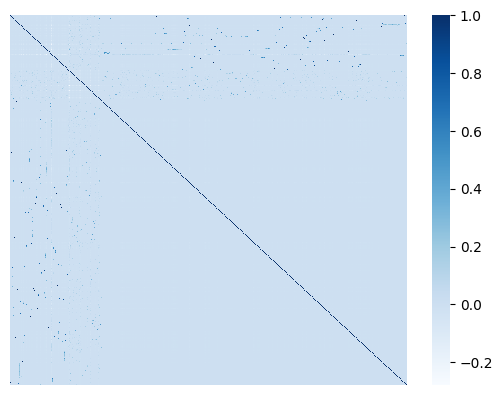

In [272]:
encode_data = pd.get_dummies(structured_system_log_df[['Component', 'User', 'EventId']], drop_first=True)
correlation_df = encode_data.corr()
sns.heatmap(correlation_df, yticklabels=False, xticklabels=False,cmap= 'Blues')


In [278]:
correlation_matrix_unstacked = correlation_df.unstack().sort_values(ascending=False)
top_correlations = correlation_matrix_unstacked[correlation_matrix_unstacked!= 1].drop_duplicates()
top_correlations.head(10) 



EventId_E188                                            Component_Microsoft Word              0.992774
Component_quicklookd                                    EventId_E214                          0.963382
EventId_E52                                             Component_sandboxd                    0.908872
EventId_E283                                            Component_com.apple.xpc.launchd       0.887628
EventId_E253                                            Component_WeChat                      0.876397
Component_syslogd                                       EventId_E153                          0.865373
Component_secd                                          EventId_E313                          0.865154
Component_com.apple.AddressBook.InternetAccountsBridge  EventId_E203                          0.860258
Component_WindowServer                                  EventId_E305                          0.824652
EventId_E309                                            Component_com.app